In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('vader_lexicon')
from nltk.stem import SnowballStemmer
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud
from nltk.corpus import stopwords
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import random
plt.rc('figure',figsize=(17,13))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Valentin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
df = pd.read_csv('vaccination_tweets.csv', dtype='str').fillna('')


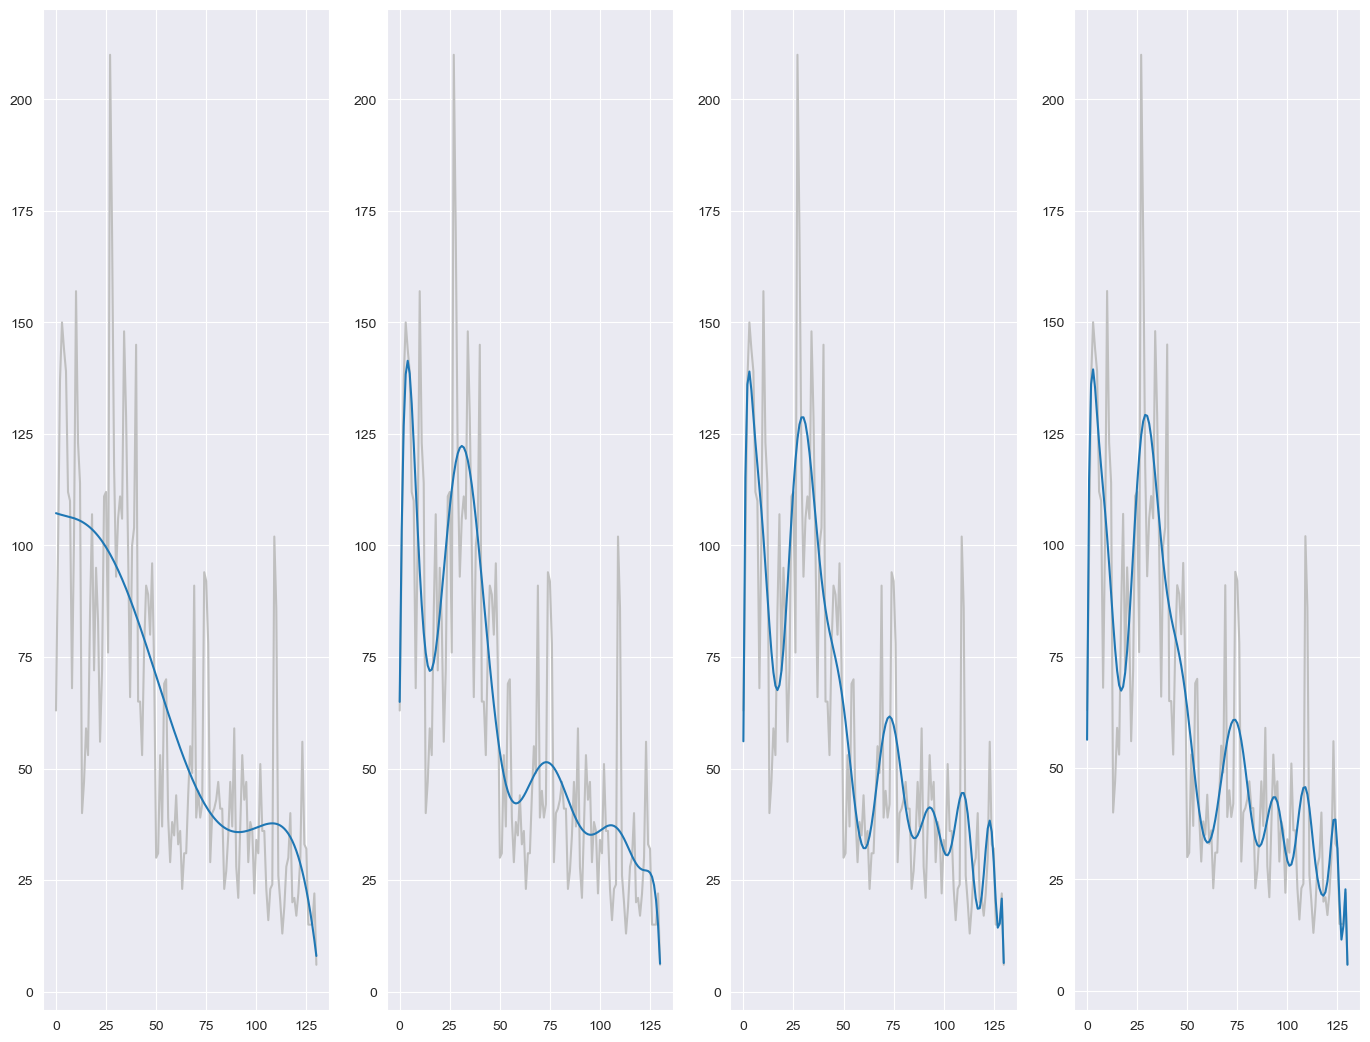

In [43]:
import plotly.graph_objects as go
df['tweet_date']=pd.to_datetime(df['date']).dt.date
tweet_date=df['tweet_date'].value_counts().to_frame().reset_index().rename(columns={'index':'date','tweet_date':'count'})
tweet_date['date']=pd.to_datetime(tweet_date['date'])
tweet_date=tweet_date.sort_values('date',ascending=False)

fig=go.Figure(go.Scatter(x=tweet_date['date'],
                                y=tweet_date['count'],
                               mode='markers+lines',
                               name="Submissions",
                               marker_color='dodgerblue'))


fig.update_layout(
    title_text='Tweets par jour : ({} - {})'.format(df['tweet_date'].sort_values()[0].strftime("%d/%m/%Y"),
                                                       df['tweet_date'].sort_values().iloc[-1].strftime("%d/%m/%Y")),
    title_x=0.5)

fig.show()

tweet_date_sorted = tweet_date.sort_values(by='date')
tweet_date_sorted['Time'] = np.arange(len(tweet_date_sorted.index))
# fig1, ax = plt.subplots()


deg = [5, 10, 25, 50]
coeffs = []
xn = tweet_date_sorted['Time']
yns = []

figs, axs = plt.subplots(nrows=1, ncols=4)
for d in deg:
    coeff = np.polyfit(tweet_date_sorted['Time'], tweet_date_sorted['count'], d)
    coeffs.append(coeff)
    yn = np.poly1d(coeff)
    yns.append(yn)

for i in range(len(deg)):
    axs[i].plot('Time', 'count', data=tweet_date_sorted, color='0.75')
    axs[i].plot(xn, yns[i](xn))
# fig1.show()

          date  count  Time        SMA7
13  2020-12-18    112     6  120.428571
17  2020-12-19    110     7  127.142857
47  2020-12-20     68     8  122.857143
23  2020-12-21    102     9  117.857143
2   2020-12-22    157    10  118.857143
..         ...    ...   ...         ...
128 2021-04-17     15   126   29.285714
127 2021-04-18     15   127   29.000000
126 2021-04-19     15   128   28.000000
117 2021-04-20     22   129   26.857143
130 2021-04-21      6   130   19.714286

[125 rows x 4 columns]


<AxesSubplot:title={'center':'MA(7) pour les tweets (positifs, négatifs et neutres)'}, xlabel='Date', ylabel='Nombre de tweets'>

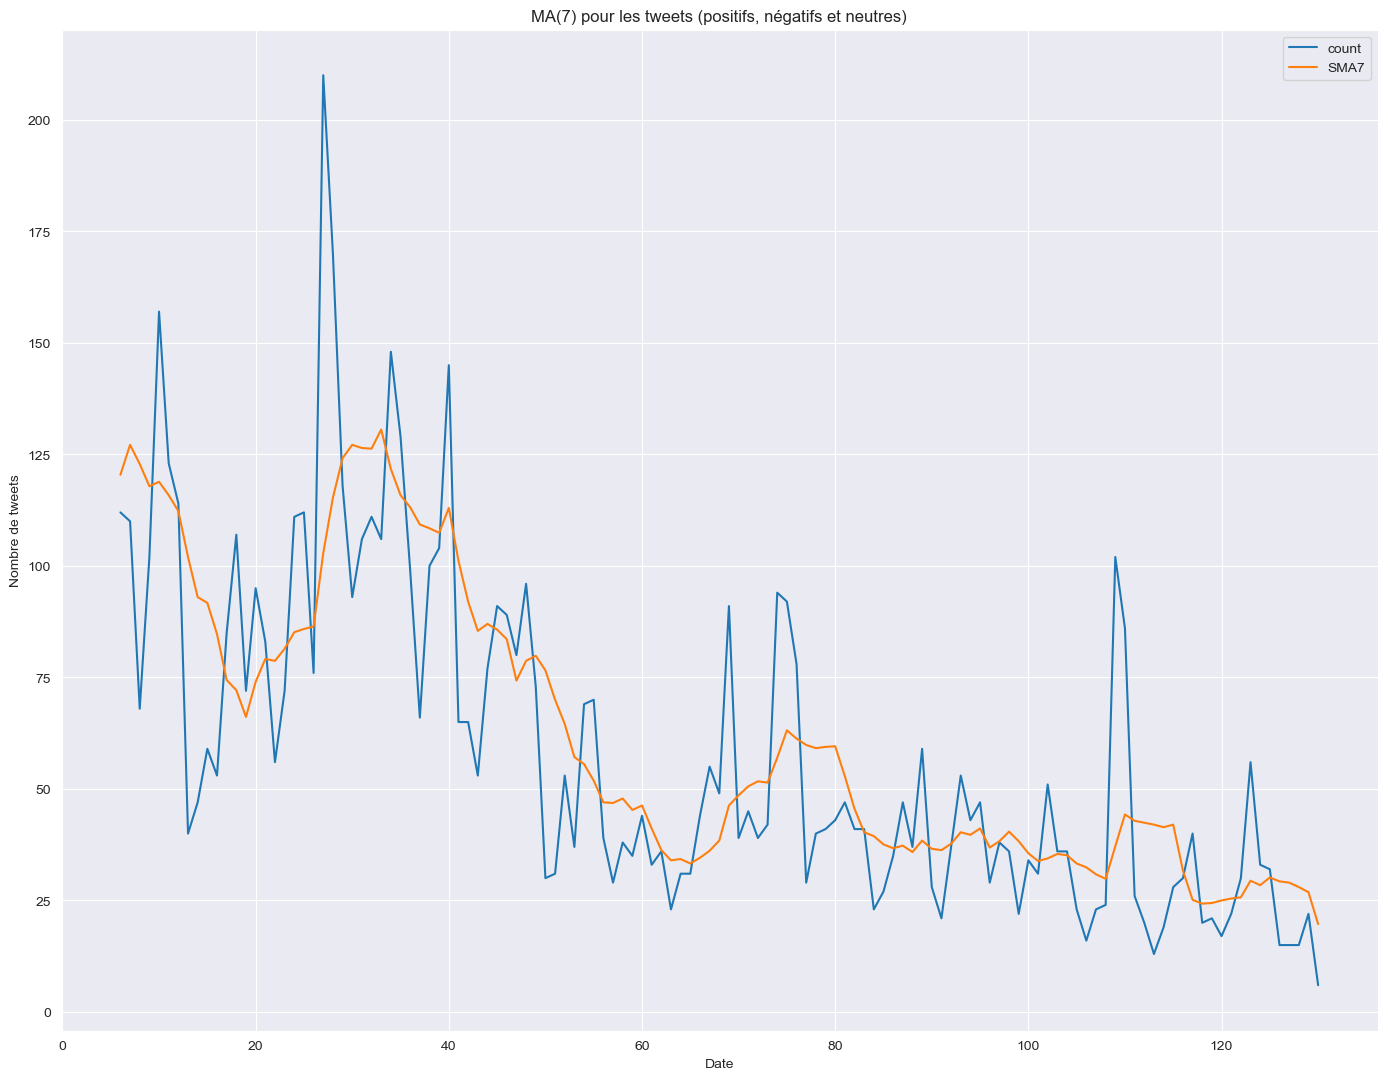

In [7]:
tweet_date_sorted['SMA7'] = tweet_date_sorted['count'].rolling(7).mean()
tweet_date_sorted.dropna(inplace=True)
print(tweet_date_sorted)
tweet_date_sorted.plot(x='Time', y=['count','SMA7'], title='MA(7) pour les tweets (positifs, négatifs et neutres)', xlabel='Date', ylabel='Nombre de tweets')

In [8]:
f_data = pd.read_csv('vaccination_tweets.csv', dtype='str').fillna('')

In [9]:
nltk.download('stopwords')
stop_words = (set(stopwords.words('english')))
sno = SnowballStemmer('english')

def remove_html_tags(sentence):
    regex = re.compile(pattern='<.*?>')
    clean_text = re.sub(regex, ' ', sentence)
    return clean_text

def remove_punctuations(word):
    cleaned_sentence = re.sub(pattern=r'[?|!|\|"|#|\']', repl=r'', string=word)
    cleaned_sentence = re.sub(pattern=r'[.|,|)|(|\|/]', repl=r'', string=cleaned_sentence)
    return cleaned_sentence

def get_preprocessed_data(data, feature, cleaned_feature):
        
        i = 0
        final_string = []

        sentences = data[feature].values
        for sentence in sentences:
            filtered_sentence = []
            sentence = remove_html_tags(sentence)
            for word in sentence.split():
                for clean_word in remove_punctuations(word).split():
                    if clean_word.isalpha() and len(clean_word) > 2:
                        if clean_word.lower() not in stop_words:
                            s = (sno.stem(clean_word.lower()))
                            filtered_sentence.append(s)

            string = " ".join(filtered_sentence)
            final_string.append(string)
            i += 1
        data[cleaned_feature] = final_string
        return data

f_data = get_preprocessed_data(f_data, 'text', 'Tidy Tweet')
f_data = get_preprocessed_data(f_data, 'hashtags', 'Tidy hashtags')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Valentin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


On va maintenant représenter la distribution des différents sentiments au sein des tweets. Pour cela, on va utiliser le score fourni par la méthode SIA( ) (SentimentIntensityAnalyzer), qui va nous permettre de caractériser la nature d'un sentiment. En effet, plus le score pour un mot se rapproche de 1, plus le mot sera polarisé (i.e positif ou négatif selon la distribution qu'on représente). A l'opposé, un score se rapprochant de 0 suggère un mot dégageant un sentiment neutre.

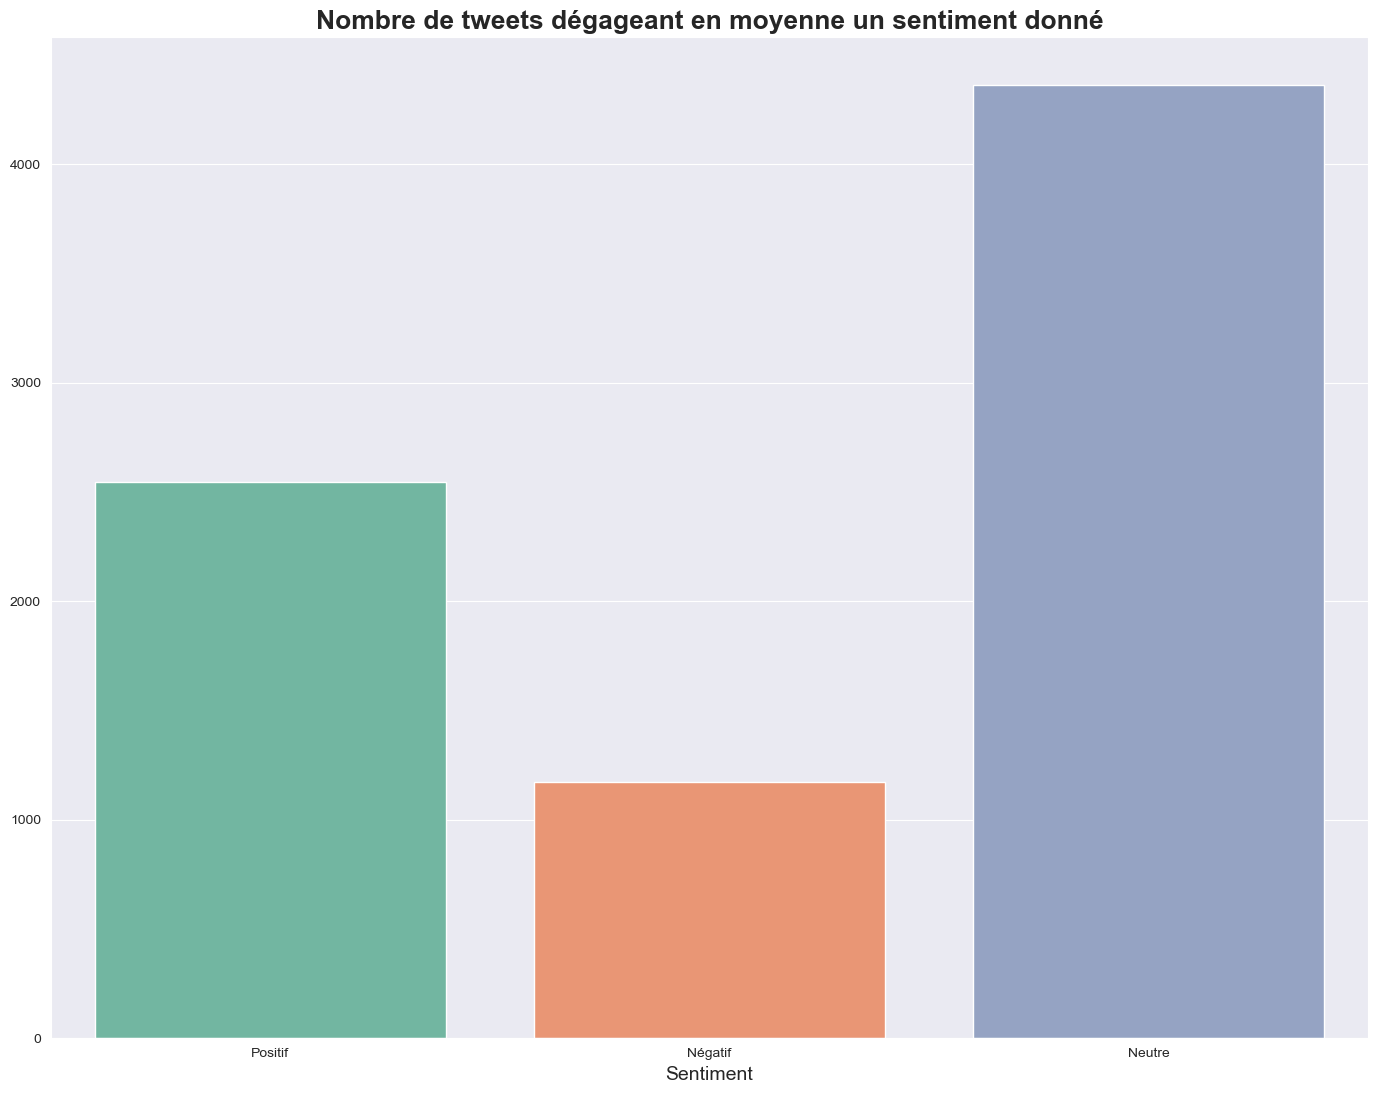

Neutre     4363
Positif    2544
Négatif    1175
Name: Sentiment, dtype: int64


In [10]:
sentiment = SIA()
def get_sentiment(data):
    sentiment_list = []
    for text in list(data['Tidy Tweet'].values):
        if sentiment.polarity_scores(text)["compound"] > 0:
            sentiment_list.append("Positif")
        elif sentiment.polarity_scores(text)["compound"] < 0:
            sentiment_list.append("Négatif")
        else:
            sentiment_list.append("Neutre")
    return sentiment_list

    
f_data['Sentiment'] = get_sentiment(f_data) # retourne un score moyen pour chaque tweet nettoyé précedemment 
sns.countplot(x="Sentiment", data=f_data, palette="Set2")
plt.title('Nombre de tweets dégageant en moyenne un sentiment donné',fontsize=19,fontweight='bold')
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('')
plt.show()
print(f_data.Sentiment.value_counts())

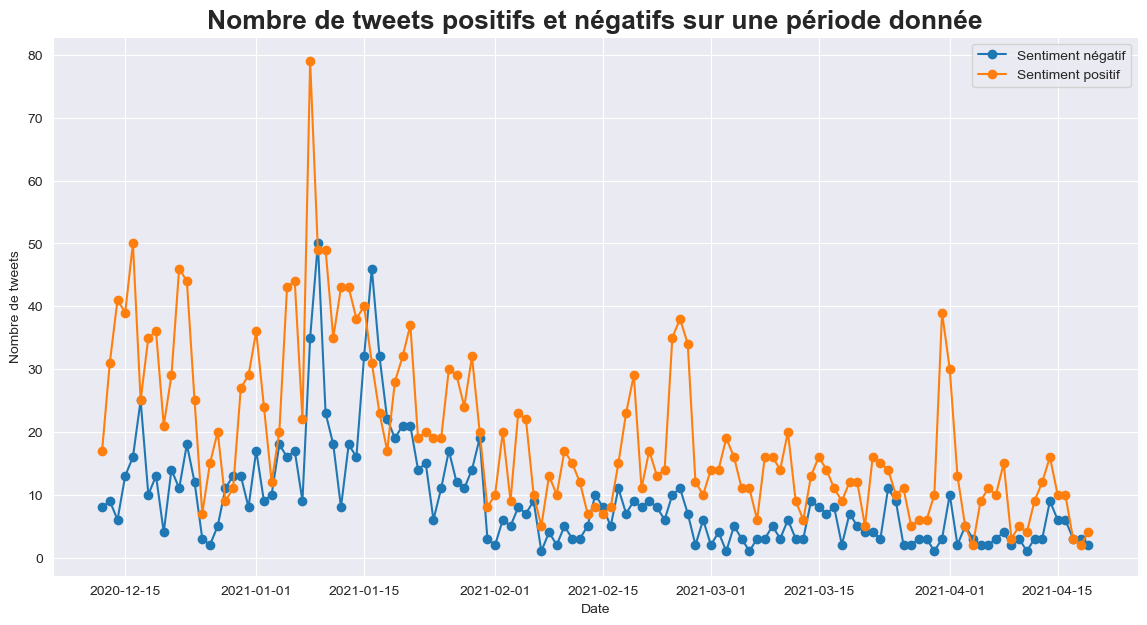

In [11]:
f_data['date'] = pd.to_datetime(f_data['date']).dt.date
negative_data = f_data[f_data['Sentiment']=='Négatif'].reset_index()
positive_data = f_data[f_data['Sentiment']=='Positif'].reset_index()
grouped_data_neg = negative_data.groupby('date')['Sentiment'].count().reset_index()
grouped_data_pos = positive_data.groupby('date')['Sentiment'].count().reset_index()
merged_data = pd.merge(grouped_data_neg, grouped_data_pos, left_on='date', right_on='date', suffixes=(' négatif', ' positif'))


merged_data.plot(x='date', y=['Sentiment négatif', 'Sentiment positif'], figsize=(14, 7), marker='o', xlabel='Date', ylabel='Nombre de tweets')
plt.title('Nombre de tweets positifs et négatifs sur une période donnée', fontweight='bold',fontsize=19)
plt.show()



In [12]:
sid = SIA()
f_data['sentiments']           = f_data['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
f_data['Positive Sentiment']   = f_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
f_data['Neutral Sentiment']    = f_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
f_data['Negative Sentiment']   = f_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

f_data.drop(columns=['sentiments'],inplace=True)
#Number of Words
f_data['Number_Of_Words'] = f_data.text.apply(lambda x:len(x.split(' ')))
#Average Word Length
f_data['Mean_Word_Length'] = f_data.text.apply(lambda x:np.round(np.mean([len(w) for w in x.split(' ')]),2) )


<AxesSubplot:title={'center':'MA(7) pour les tweets négatifs'}, xlabel='Date', ylabel='Nombre de tweets'>

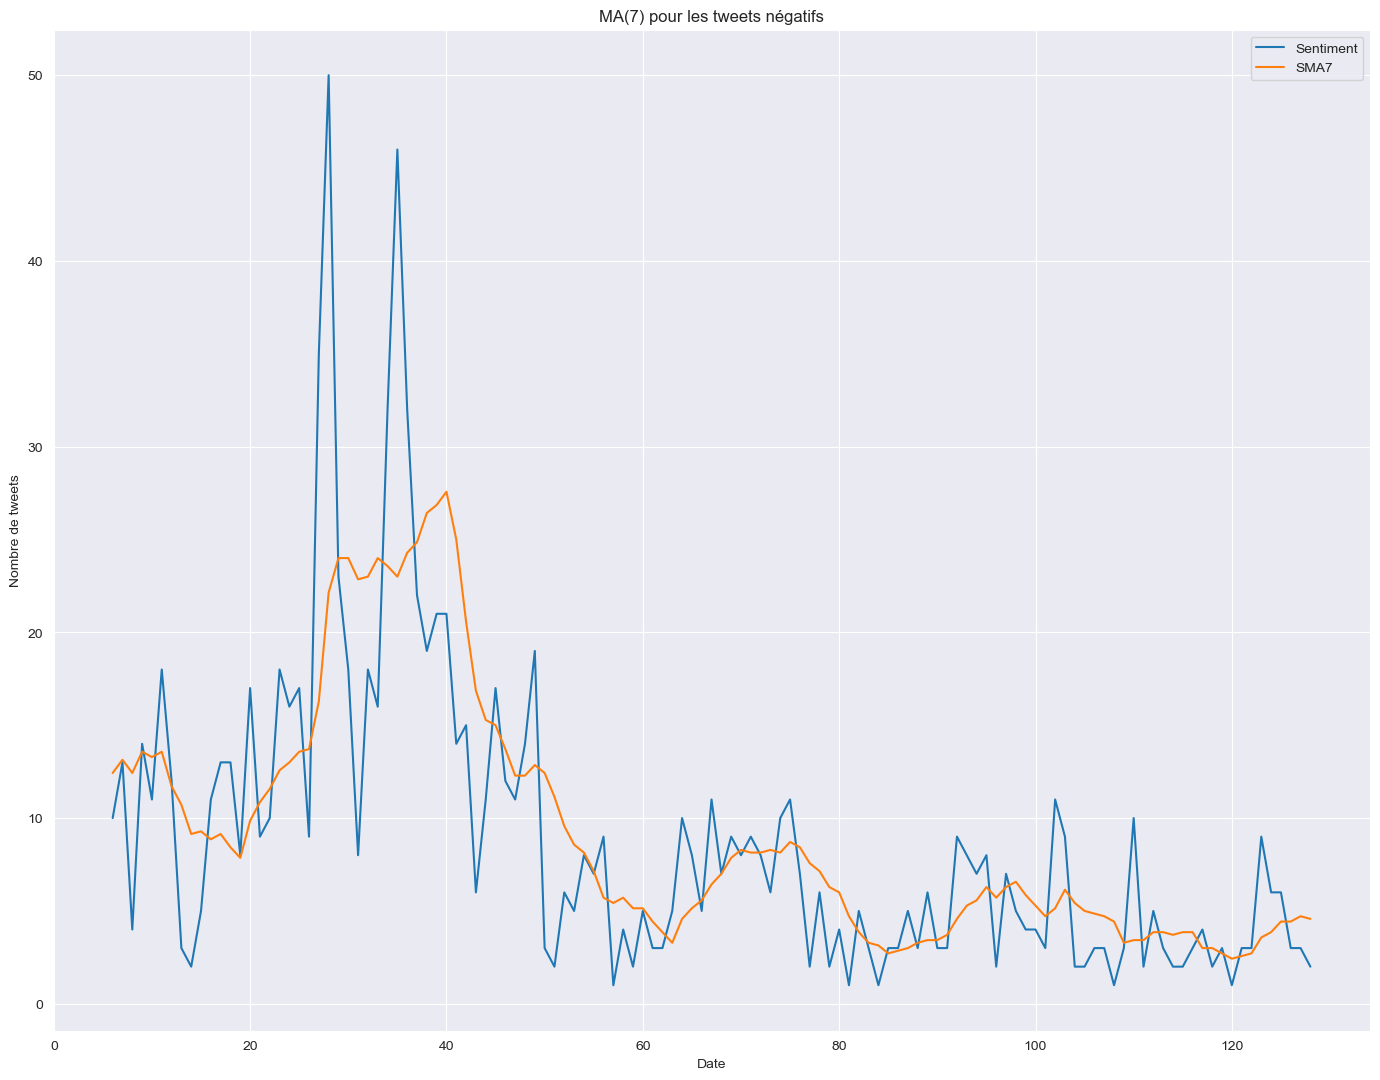

In [13]:
grouped_data_neg['Time'] = np.arange(len(grouped_data_neg.index))
grouped_data_neg['SMA7'] = grouped_data_neg['Sentiment'].rolling(7).mean()
grouped_data_neg.dropna(inplace=True)
grouped_data_neg
grouped_data_neg.plot(x='Time', y=['Sentiment','SMA7'], title='MA(7) pour les tweets négatifs', xlabel='Date', ylabel='Nombre de tweets')



<AxesSubplot:title={'center':'MA(7) pour les tweets positifs'}, xlabel='Date', ylabel='Nombre de tweets'>

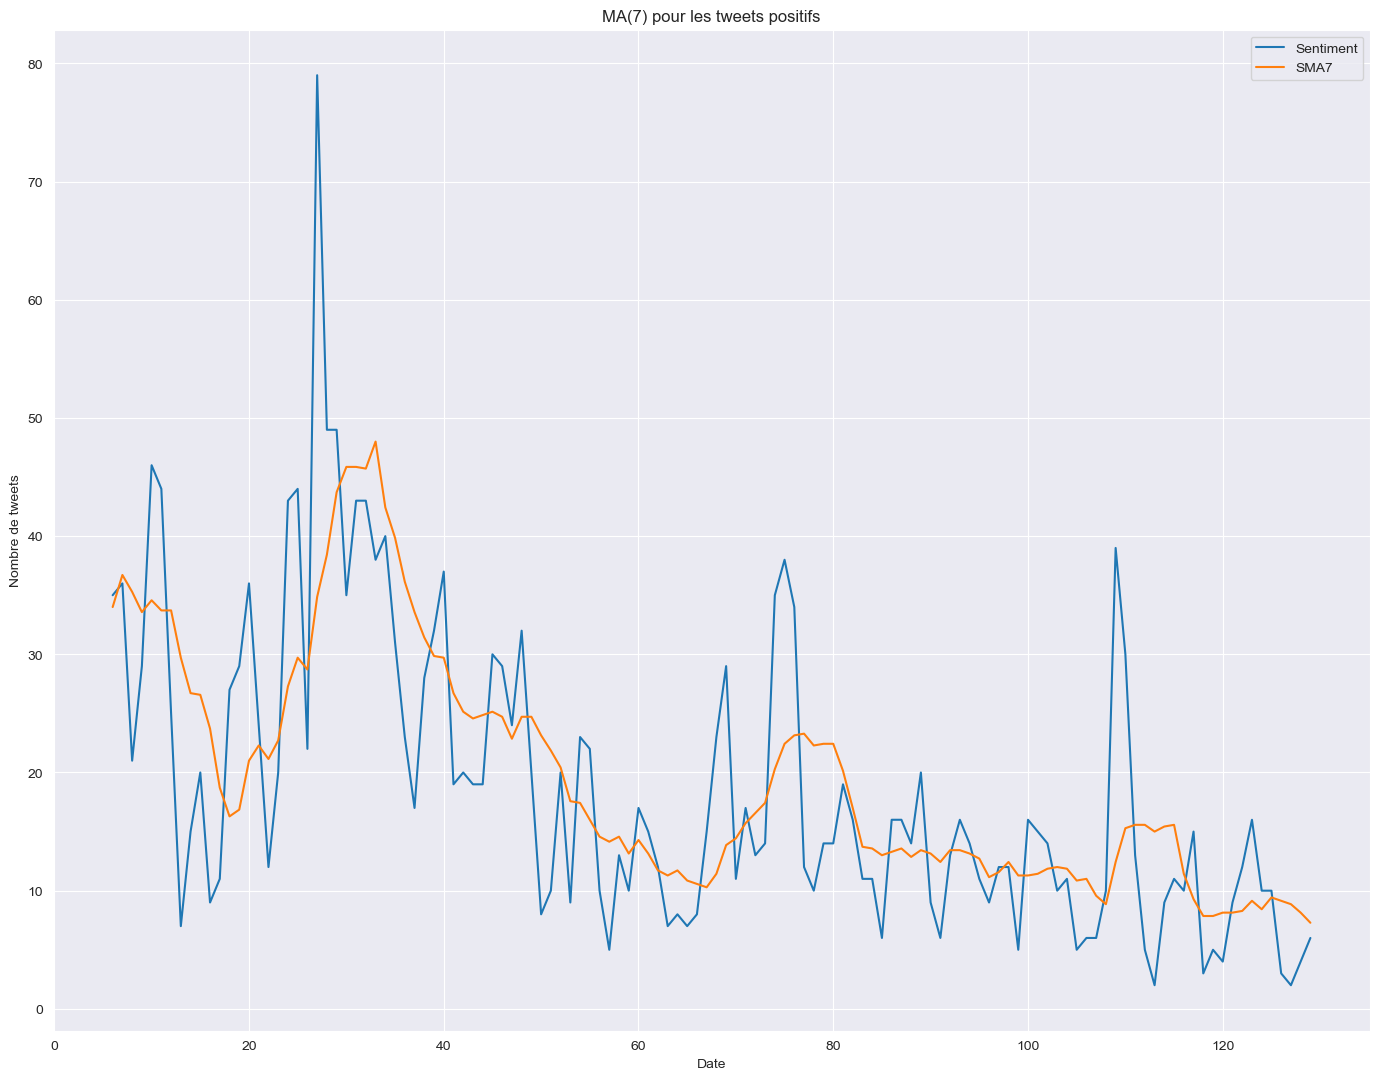

In [14]:
grouped_data_pos['Time'] = np.arange(len(grouped_data_pos.index))
grouped_data_pos['SMA7'] = grouped_data_pos['Sentiment'].rolling(7).mean()
grouped_data_pos.dropna(inplace=True)
grouped_data_pos.plot(x='Time', y=['Sentiment','SMA7'], title='MA(7) pour les tweets positifs', xlabel='Date', ylabel='Nombre de tweets')

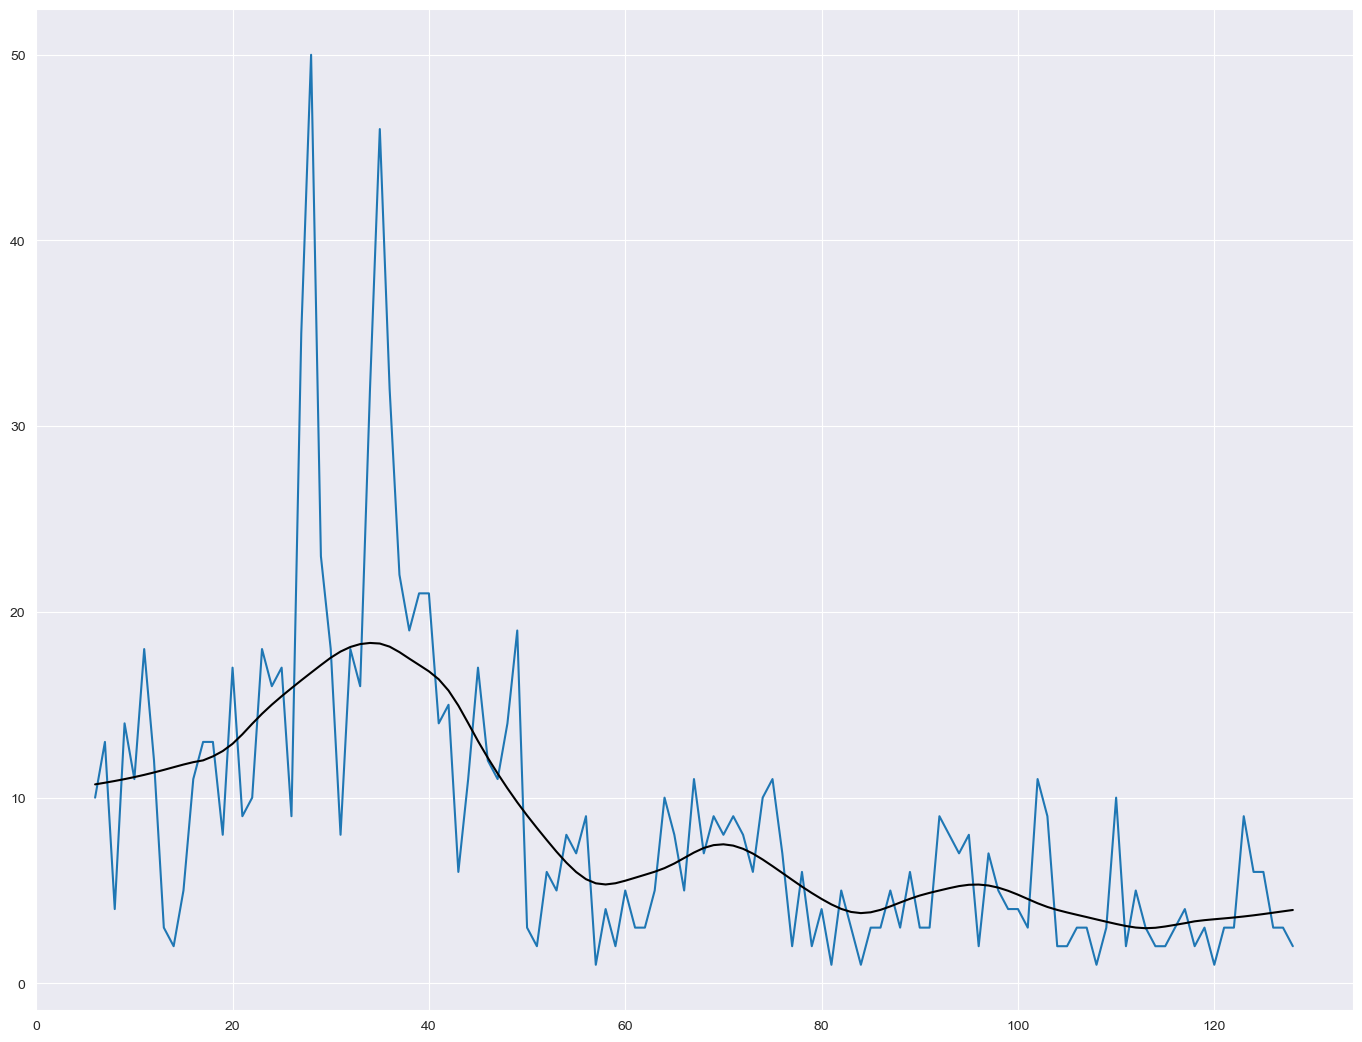

In [29]:
from scipy.interpolate import interp1d
import statsmodels.api as sm

# introduce some floats in our x-values
x = grouped_data_neg['Time']
y = grouped_data_neg['Sentiment']

# lowess will return our "smoothed" data with a y value for at every x-value
lowess = sm.nonparametric.lowess(y, x, frac=.2)

# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]



plt.plot(x, y)
plt.plot(lowess_x, lowess_y, '-', color='black')
plt.title('Régression LOESS sur les tweets renvoyant un snetiment négatif')
plt.show()

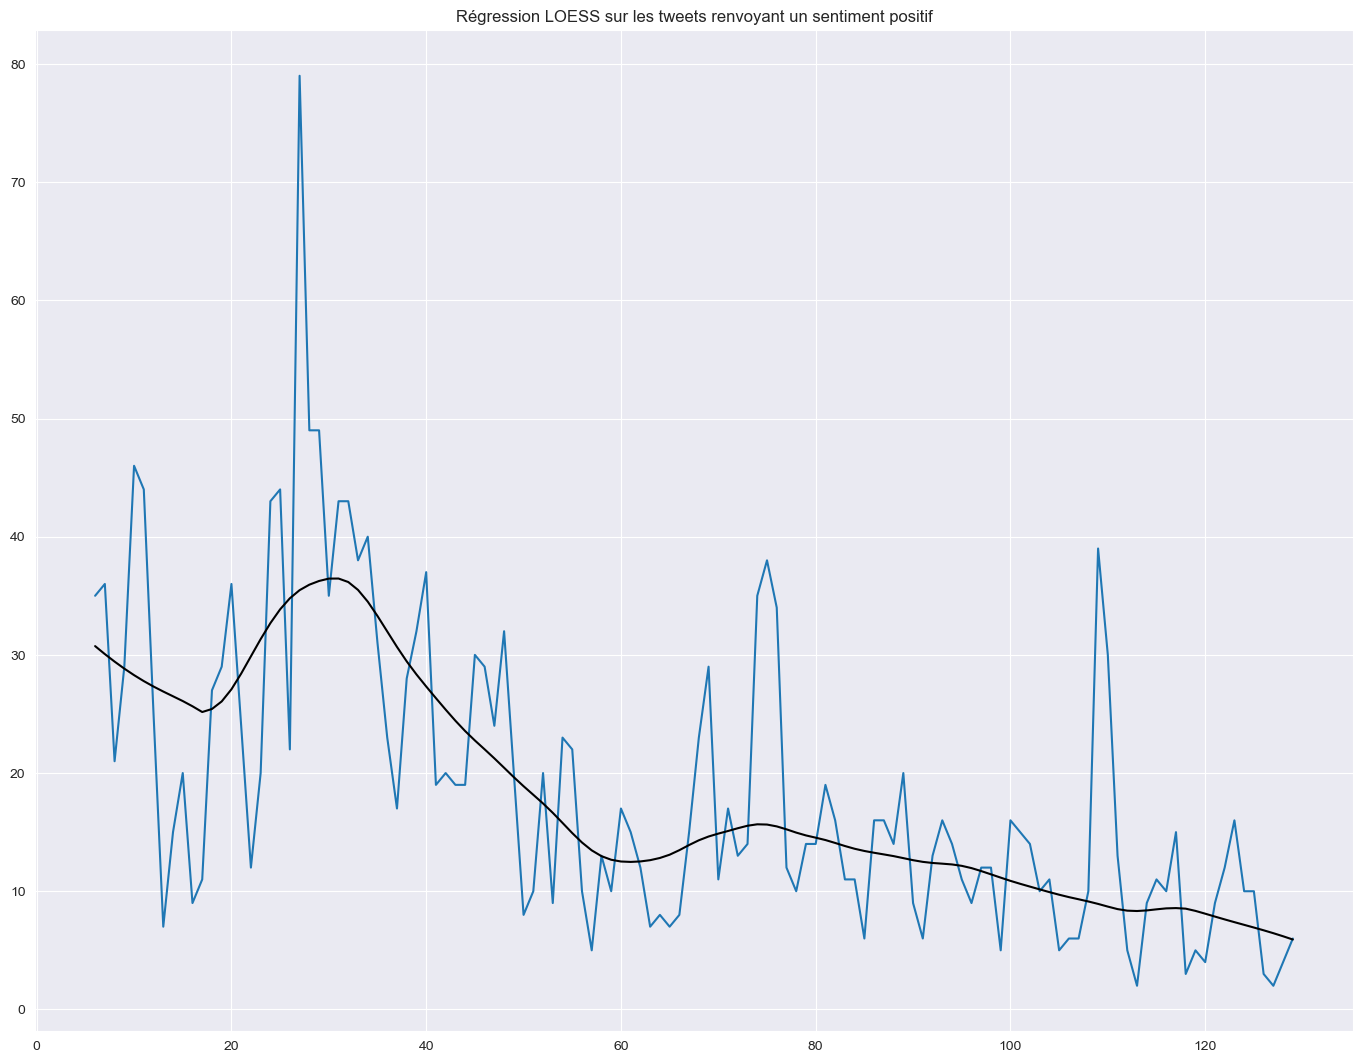

In [30]:
x = grouped_data_pos['Time']
y = grouped_data_pos['Sentiment']

# lowess will return our "smoothed" data with a y value for at every x-value
lowess = sm.nonparametric.lowess(y, x, frac=.2)

# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]



plt.plot(x, y)
plt.plot(lowess_x, lowess_y, '-', color='black')
plt.title('Régression LOESS sur les tweets renvoyant un sentiment positif')
plt.show()

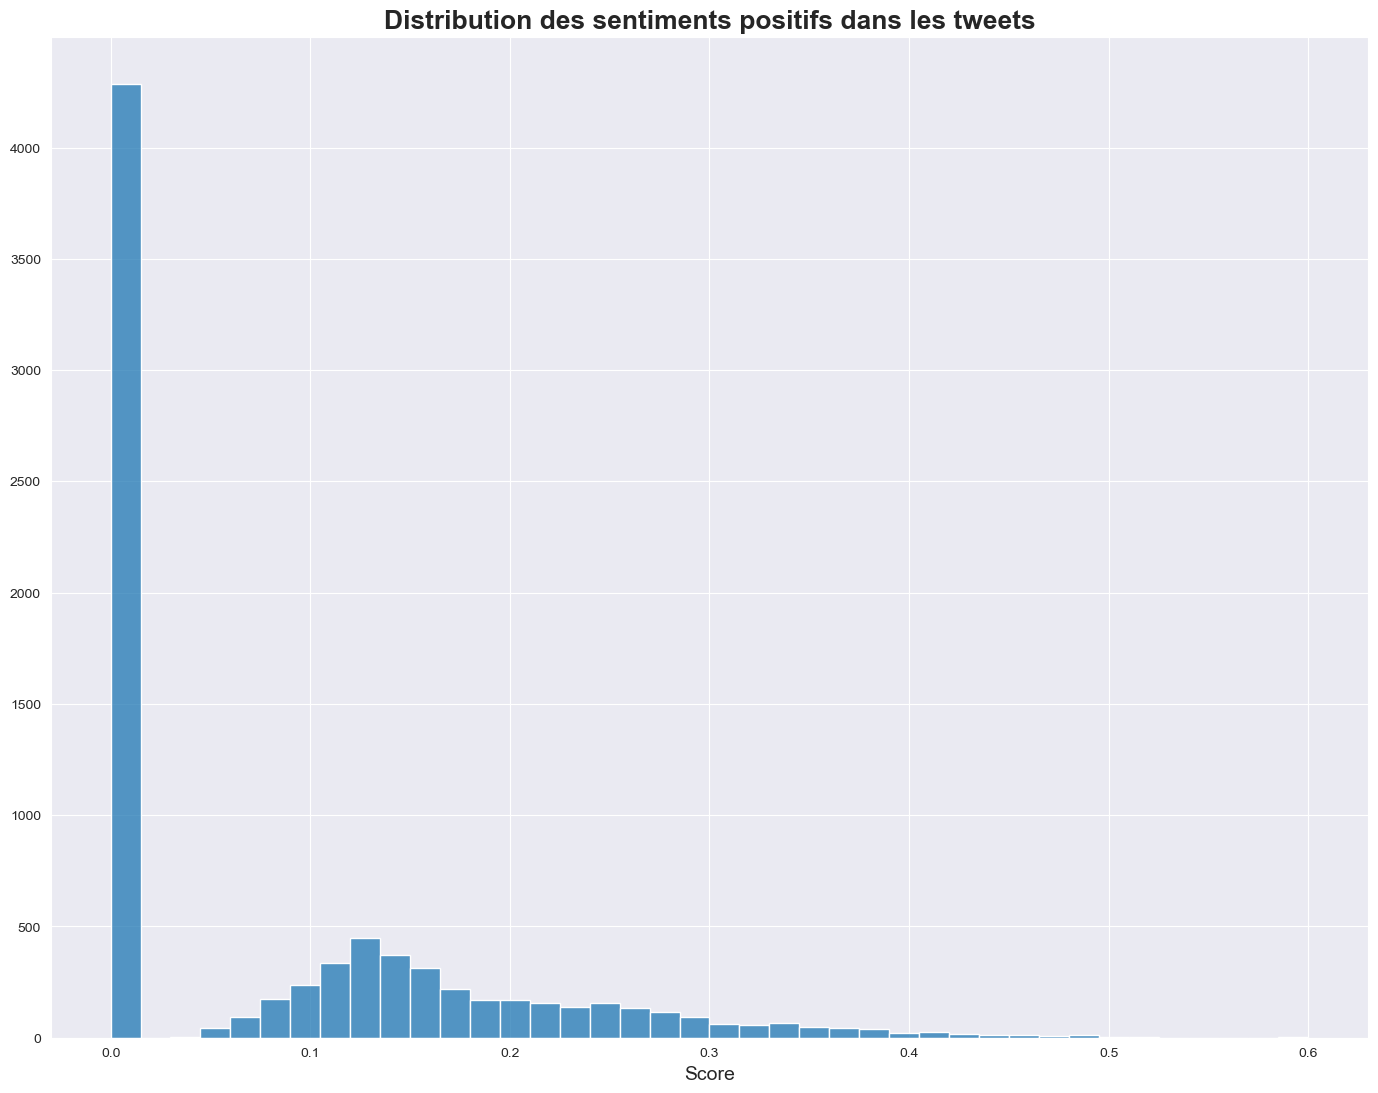

In [16]:
import warnings
warnings.filterwarnings("ignore")
plt.title('Distribution des sentiments positifs dans les tweets',fontsize=19,fontweight='bold')
sns.histplot(f_data['Positive Sentiment'])
plt.xlabel('Score',fontsize=14)
plt.ylabel('')
plt.show()

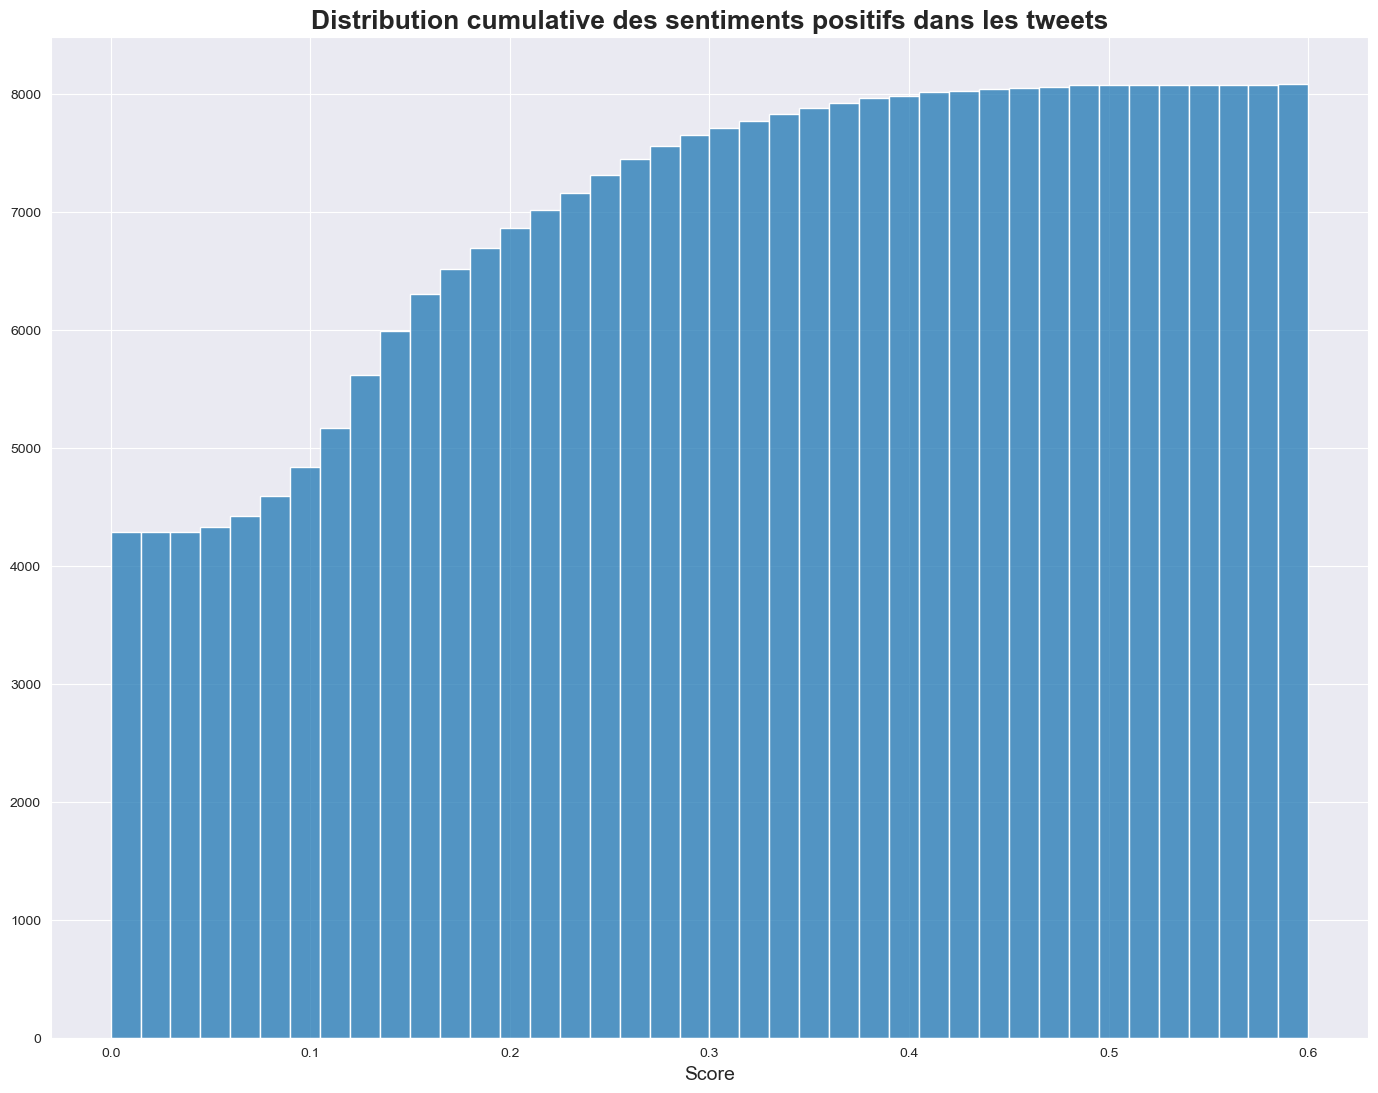

In [17]:
plt.title('Distribution cumulative des sentiments positifs dans les tweets',fontsize=19,fontweight='bold')
sns.histplot(f_data['Positive Sentiment'],cumulative=True)
plt.xlabel('Score',fontsize=14)
plt.ylabel('')
plt.show()



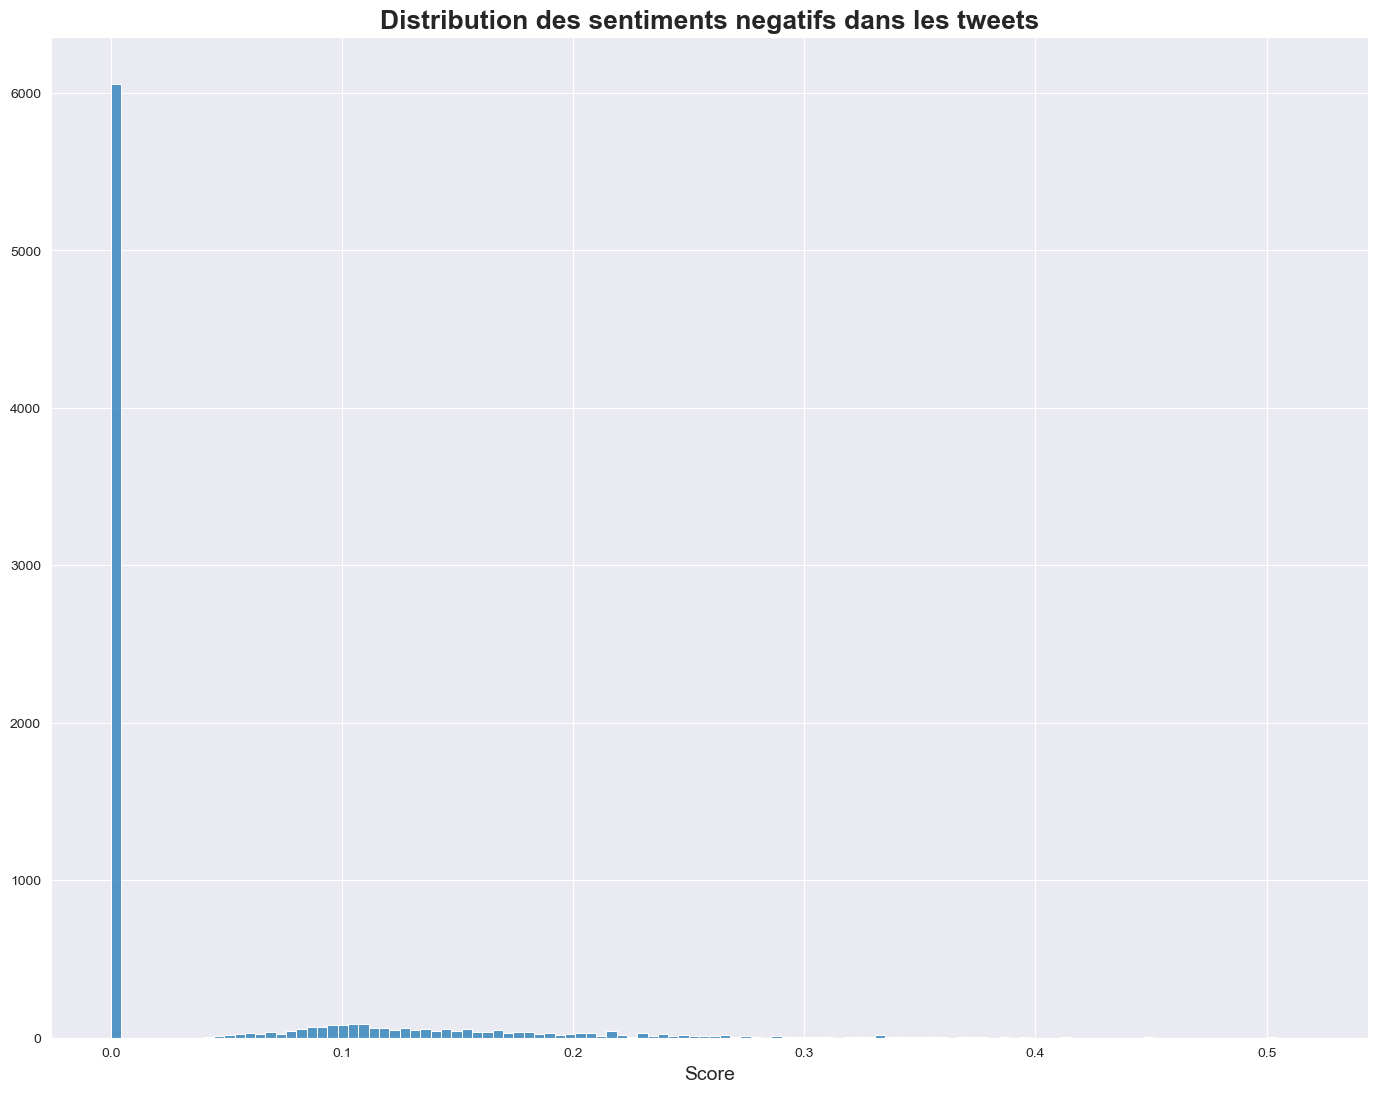

In [18]:
plt.title('Distribution des sentiments negatifs dans les tweets',fontsize=19,fontweight='bold')
sns.histplot(f_data['Negative Sentiment'])
plt.xlabel('Score',fontsize=14)
plt.ylabel('')
plt.show()

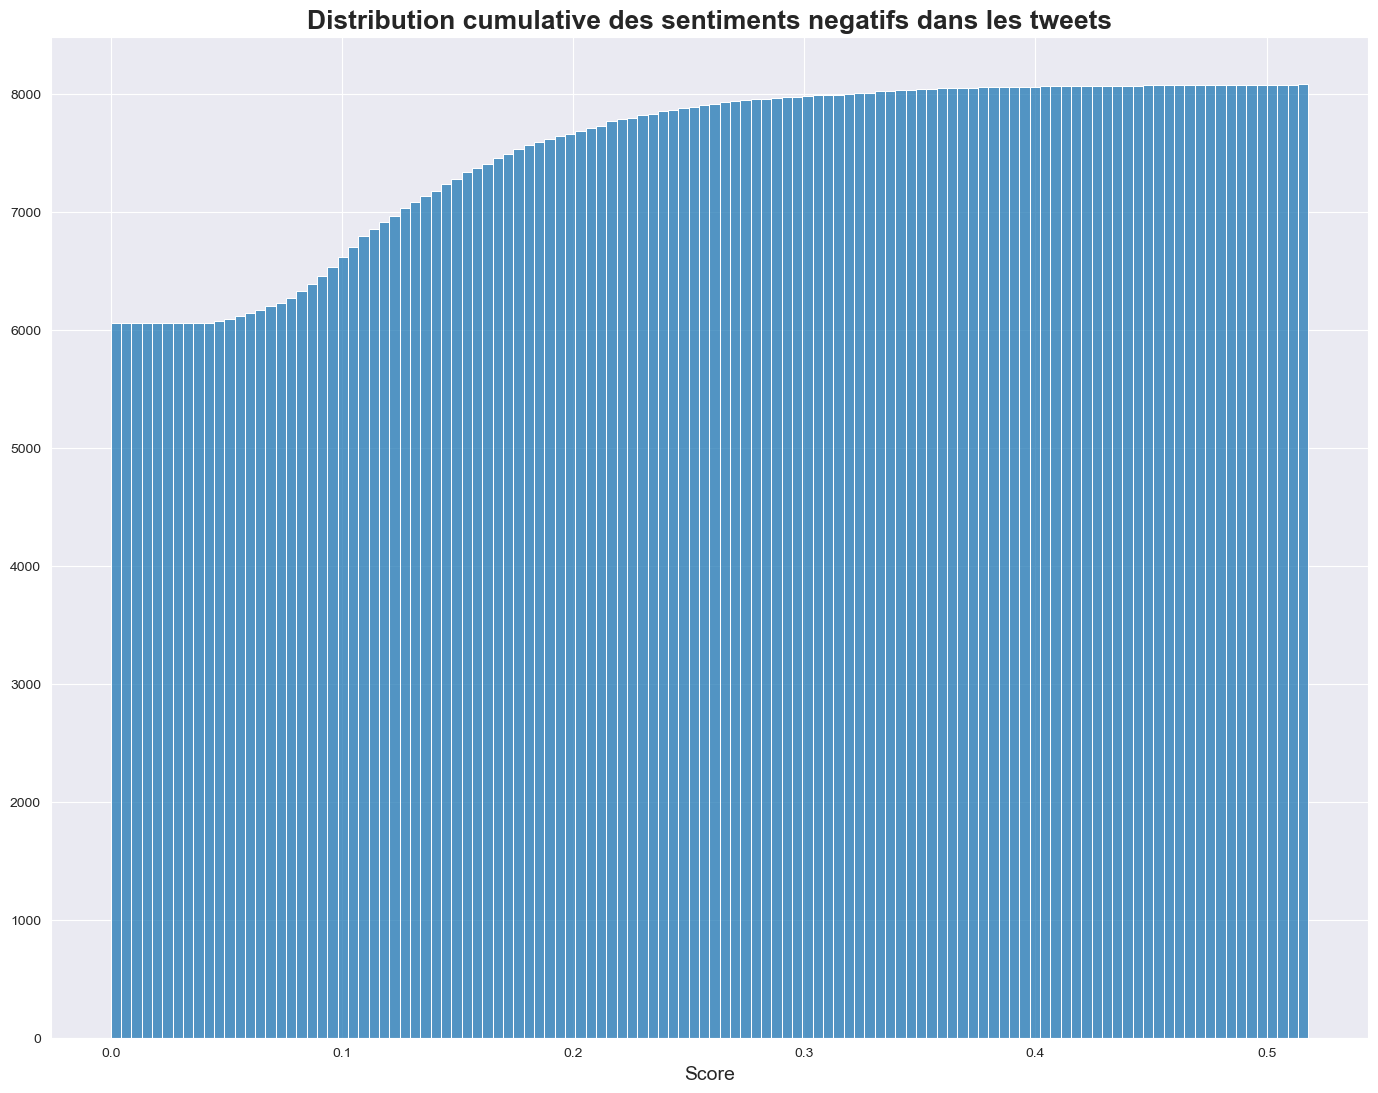

In [19]:
plt.title('Distribution cumulative des sentiments negatifs dans les tweets',fontsize=19,fontweight='bold')
sns.histplot(f_data['Negative Sentiment'],cumulative=True)
plt.xlabel('Score',fontsize=14)
plt.ylabel('')
plt.show()

In [20]:
df_by_date = df.sort_values(by='date')
df_by_date
df_by_date['Time'] = np.arange(len(df_by_date.index))
df_by_date

id                                          user_name  \
44    1337727767551553536                                   Daily News Egypt   
43    1337728701820268544                                          City A.M.   
42    1337732077278662657                                             mystic   
41    1337732996380696578                                           KHuntson   
40    1337733048914358272  Party politics isn't working for anyone, anywhere   
...                   ...                                                ...   
7867  1384693644318281730                                              CCTV+   
7866  1384769921620406275                                      Khaleej Times   
7865  1384770521988886528                                 Spike In Hong Kong   
7864  1384787559876894720                                       Andrea Gerák   
7863  1384787916187123713                                       Julika Brand   

              user_location  \
44                    Egypt   
43          London, England   
42                            
41                    USA🇺🇸   
40    Wales, United Kingdom   
...                     ...   
7867         Beijing, CHINA   
7866   United Arab Emirates   
7865              Hong Kong   
7864               Budapest   
7863        Allgäu (Bayern)   

                                       user_description         user_created  \
44    Egypt's Only Daily Independent Newspaper in En...  2009-04-26 07:56:24   
43    London's business newspaper - News, Opinion, a...  2009-06-09 13:53:06   
42               I believe in the goodness of humanity.  2020-05-20 10:57:00   
41    RN, health educator, writer, researcher, wife,...  2014-01-31 01:25:24   
40    No lie to another is respectful; no lie to you...  2016-08-03 20:11:00   
...                                                 ...                  ...   
7867  CCTV+ is a leading video news agency in China ...  2015-01-16 04:52:01   
7866  The official Twitter feed of Khaleej Times, th...  2009-01-11 07:56:56   
7865  Global Technology Leader, Writer, Photographer...  2008-05-31 14:51:17   
7864  🇭🇺 #Hungarian Singer \n❤️ #Hungary #Travel #He...  2008-05-27 13:59:55   
7863  I want to be around a really long time.\nI wan...  2011-12-09 16:39:29   

     user_followers user_friends user_favourites user_verified  \
44           278080          116             765          True   
43            66224          603             771          True   
42               14          162            1341         False   
41             2035         1672            6734         False   
40              761          504           33675         False   
...             ...          ...             ...           ...   
7867          28591          277             352          True   
7866         625962         1204             581          True   
7865           4126         1562             394         False   
7864           2047         1536           40504         False   
7863           3214         2526           51074         False   

                     date                                               text  \
44    2020-12-12 11:55:28  #FDA authorizes #PfizerBioNTech #coronavirus v...   
43    2020-12-12 11:59:10  Trump announces #vaccine rollout 'in less than...   
42    2020-12-12 12:12:35  #CovidVaccine #Pfizer-BioNTech COVID-19 #Pfize...   
41    2020-12-12 12:16:14  FACT SHEET FOR RECIPIENTS AND CAREGIVERS\n\n#P...   
40    2020-12-12 12:16:27  @mirekR9 @sputnikvaccine @AstraZeneca it's the...   
...                   ...                                                ...   
7867  2021-04-21 02:21:05  #Israel has confirmed 8 cases of the #coronavi...   
7866  2021-04-21 07:24:11  #AbuDhabi has approved the Pfizer-BioNTech vac...   
7865  2021-04-21 07:26:34  Today marks 2 weeks since I got my 2nd shot of...   
7864  2021-04-21 08:34:17  Oh.\n@kkariko Karikó letiltott 1 kérdés miatt:...   
7863  2021-04-21 08:35:41  people who got 2 shots of th